In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [3]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/test',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 15 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [4]:
conv_base = VGG16(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [5]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)


In [6]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [7]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,
                              validation_data=validation_generator)

Epoch 1/3
1/1 [==============================] - 10s 10s/step - loss: 1.2568 - accuracy: 0.6667 - val_loss: 2.3115 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 8s 8s/step - loss: 0.4284 - accuracy: 0.8000 - val_loss: 2.3608 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 8s 8s/step - loss: 0.2775 - accuracy: 0.8000 - val_loss: 2.4639 - val_accuracy: 0.6000


In [8]:

model.save('models/keras/model.h5')


model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

In [9]:

model = load_model('models/keras/model.h5')


with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

In [10]:
validation_img_paths = ["data/test/jdepp/2.jpg",
                        "data/test/rahul/1.jpg",
                        "data/test/rahul/4.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [11]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [12]:
pred_probs = model.predict(validation_batch)

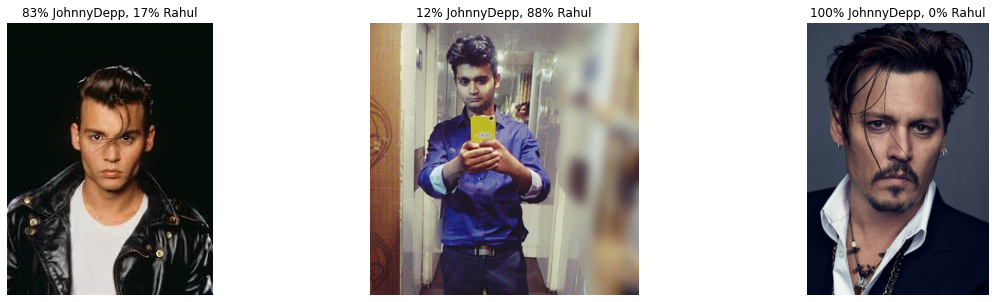

In [13]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% JohnnyDepp, {:.0f}% Rahul".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)